#### Inicialização de variáveis e importação de bibliotecas

In [12]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.models import Sequential
from keras import layers, Input


AUTOTUNE = tf.data.AUTOTUNE

batch_size = 32
img_height = 230
img_width = 230
data_dir='data/cuted/'
predict_dir='predict/'

#### Definição dos diretórios de treinamento e validação
    



O primeiro conjunto de dados, ```train_ds```, é para treinamento. Lendo imagens do diretório especificado em data_dir, dividindo 20% dos dados para validação (deixando 80% para treinamento) com a opção ```validation_split=0.2```, e especificando que este é o conjunto de "treinamento" com ```subset="training"```. Você também está definindo uma semente para a divisão dos dados com ```seed=123```, redimensionando todas as imagens para o tamanho especificado em ```(img_height, img_width)```, e definindo o tamanho do lote com ```batch_size```.

O segundo conjunto de dados, val_ds, é para validação. As opções são as mesmas, exceto que subset é definido como "validation", indicando que este conjunto de dados deve ser a parte de validação da divisão.

In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4463 files belonging to 2 classes.
Using 3571 files for training.
Found 4463 files belonging to 2 classes.
Using 892 files for validation.


In [14]:
class_names = train_ds.class_names
print(class_names)

['header', 'non-header']


#### Plotagem de imagens de treinamento e suas classes



Criação de gráfico de 3x3 que mostra 9 imagens de treinamento e suas classes correspondentes. Usando o conjunto de dados de treinamento, train_ds, e iterando sobre ele para obter um lote de imagens e rótulos. Permitindo a plotagem das imagens e rótulos correspondentes.

2024-04-16 19:17:54.951410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


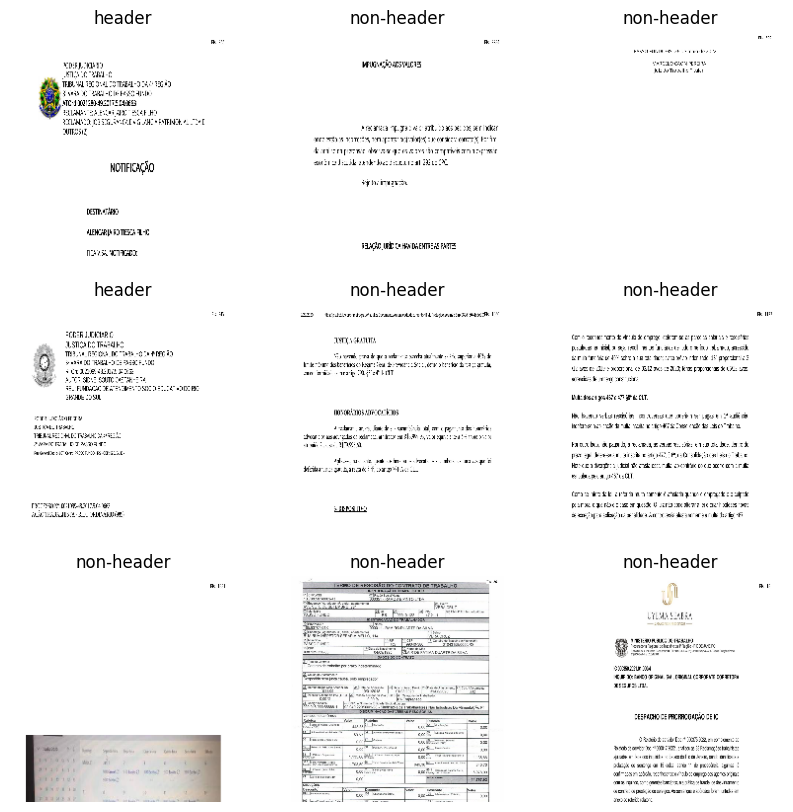

In [15]:
import matplotlib.pyplot as plt
i=0
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#### Otimização de desempenho dos conjuntos de dados


```.cache()```: mantém os dados na memória depois de serem carregados do disco. Isso garante que o conjunto de dados não precisa ser recarregado a cada época, melhorando o desempenho.  

```.shuffle(1000)```: randomiza a ordem dos exemplos no conjunto de dados de treinamento. Isso é importante para evitar que o modelo aprenda dependências indesejadas da ordem dos exemplos.  

```.prefetch(buffer_size=AUTOTUNE)``` antecipa o carregamento dos dados para a próxima época enquanto o modelo está treinando na época atual. Isso melhora o desempenho ao reduzir o tempo de inatividade entre as épocas. AUTOTUNE permite que o TensorFlow escolha automaticamente o número de lotes para antecipar.  


Para o conjunto de dados de validação, apenas ```.cache()``` e ```.prefetch(buffer_size=AUTOTUNE)``` são usados, pois não é necessário embaralhar os exemplos.

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Padronização dos dados



Normalização dos valores de pixel das imagens para que estejam no intervalo de [0, 1]. Isso é feito dividindo cada valor de pixel por 255, pois um canal RGB tem valores de pixel no intervalo [0, 255].

In [17]:
normalization_layer = keras.layers.Rescaling(1./255)

#### Definição do Modelo



```num_classes = len(class_names)```: Define o número de classes que o modelo precisa prever. Isso é baseado no número de nomes de classes fornecidos.

```model = Sequential()```: Inicia a definição de um novo modelo sequencial. Modelos sequenciais são uma pilha linear de camadas.

```Input(shape=(img_height, img_width, 3))```: Define a forma da entrada para o modelo. Neste caso, a entrada é uma imagem colorida (3 canais para vermelho, verde e azul) com altura e largura especificadas.

```layers.Rescaling(1./255)```: Reescala os valores de pixel da imagem para o intervalo [0,1].

```layers.Conv2D(16, 3, padding='same', activation='relu')```: Adiciona uma camada convolucional 2D com 16 filtros, um tamanho de kernel de 3 e ativação ReLU.

```layers.MaxPooling2D()```: Adiciona uma camada de pooling para reduzir a dimensionalidade espacial.

As próximas duas camadas Conv2D e MaxPooling2D são semelhantes à 5ª e 6ª linha, mas com mais filtros na camada convolucional.

```layers.Flatten()```: Achata a saída da última camada de pooling para um vetor unidimensional.

```layers.Dense(128, activation='relu')```: Adiciona uma camada densamente conectada com 128 neurônios e ativação ReLU.

```layers.Dense(num_classes)```: Adiciona uma camada densa final com um número de neurônios igual ao número de classes. Esta camada produz a saída do modelo.

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

2024-04-16 19:18:05.471785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:42: Filling up shuffle buffer (this may take a while): 47 of 1000
2024-04-16 19:18:16.260198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-04-16 19:18:16.262032: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 20313728 bytes after encountering the first element of size 20313728 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-04-16 19:18:16.262645: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 20313728 bytes after encountering the first element of size 20313728 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-04-16 19:18:17.067473: W tensorfl

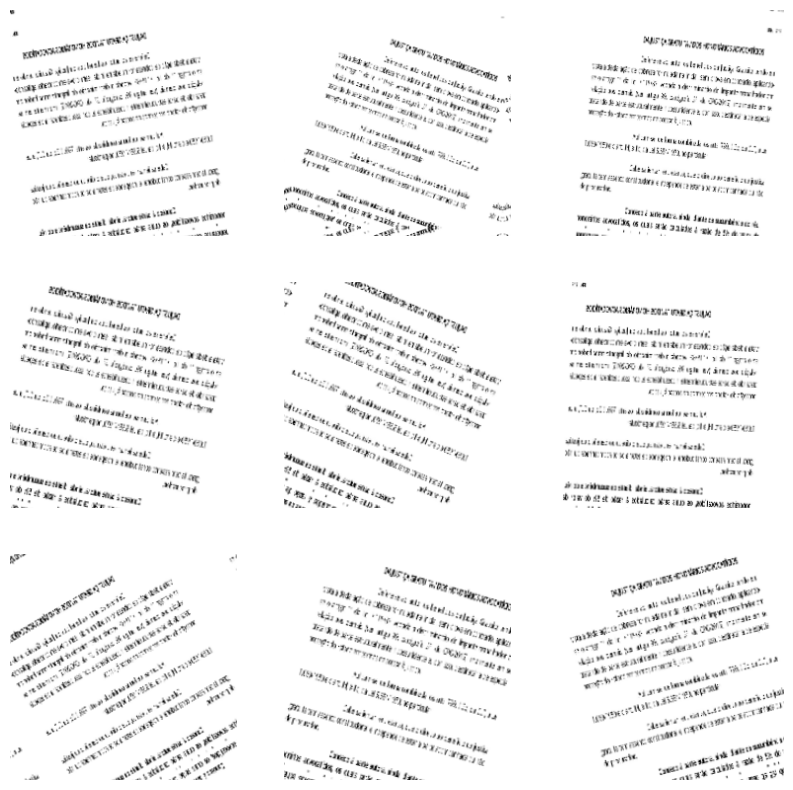

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [20]:
num_classes = len(class_names)

model = Sequential([
  layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_3 (RandomFlip)      │ (None, 230, 230, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_3               │ (None, 230, 230, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_3 (RandomZoom)      │ (None, 230, 230, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 230, 230, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 230, 230, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 115, 115, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 115, 115, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 57, 57, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 57, 57, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,446,498 (24.59 MB)

 Trainable params: 6,446,498 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
epochs = 60
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)



Epoch 1/60
112/112 ━━━━━━━━━━━━━━━━━━━━ 37s 308ms/step - accuracy: 0.7476 - loss: 1.0762 - val_accuracy: 0.8913 - val_loss: 0.3019
Epoch 2/60
112/112 ━━━━━━━━━━━━━━━━━━━━ 30s 270ms/step - accuracy: 0.8833 - loss: 0.3437 - val_accuracy: 0.6626 - val_loss: 0.8813
Epoch 3/60
112/112 ━━━━━━━━━━━━━━━━━━━━ 29s 261ms/step - accuracy: 0.9029 - loss: 0.3116 - val_accuracy: 0.8061 - val_loss: 0.5845
Epoch 4/60
112/112 ━━━━━━━━━━━━━━━━━━━━ 41s 260ms/step - accuracy: 0.9269 - loss: 0.2578 - val_accuracy: 0.8700 - val_loss: 0.4089
Epoch 5/60
112/112 ━━━━━━━━━━━━━━━━━━━━ 29s 257ms/step - accuracy: 0.9230 - loss: 0.2293 - val_accuracy: 0.9148 - val_loss: 0.2526
Epoch 6/60
112/112 ━━━━━━━━━━━━━━━━━━━━ 29s 257ms/step - accuracy: 0.9286 - loss: 0.2201 - val_accuracy: 0.8229 - val_loss: 1.1849
Epoch 7/60
112/112 ━━━━━━━━━━━━━━━━━━━━ 29s 256ms/step - accuracy: 0.9353 - loss: 0.1895 - val_accuracy: 0.9294 - val_loss: 0.1920
Epoch 8/60
112/112 ━━━━━━━━━━━━━━━━━━━━ 29s 256ms/step - accuracy: 0.9301 - loss: 0

In [23]:
model.save('model.keras')

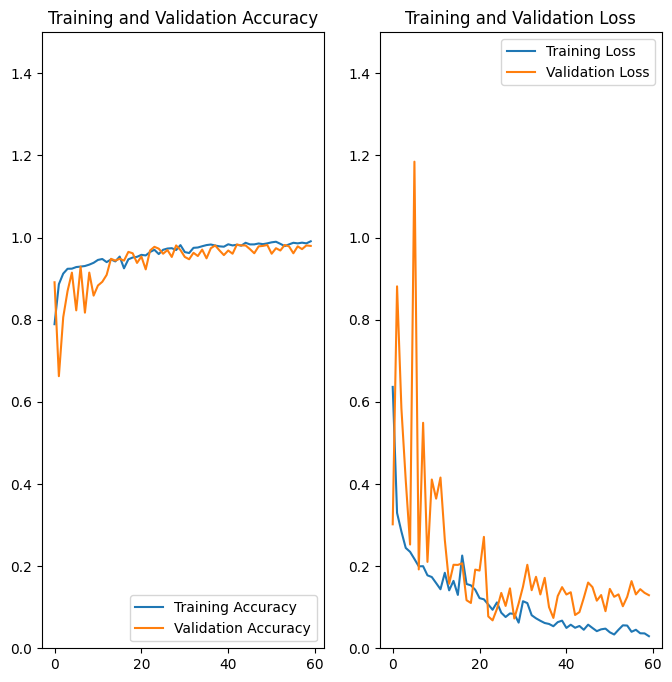

In [24]:


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylim([0, 1.5]) 

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylim([0, 1.5])
plt.show()

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


2024-04-16 19:59:57.431231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


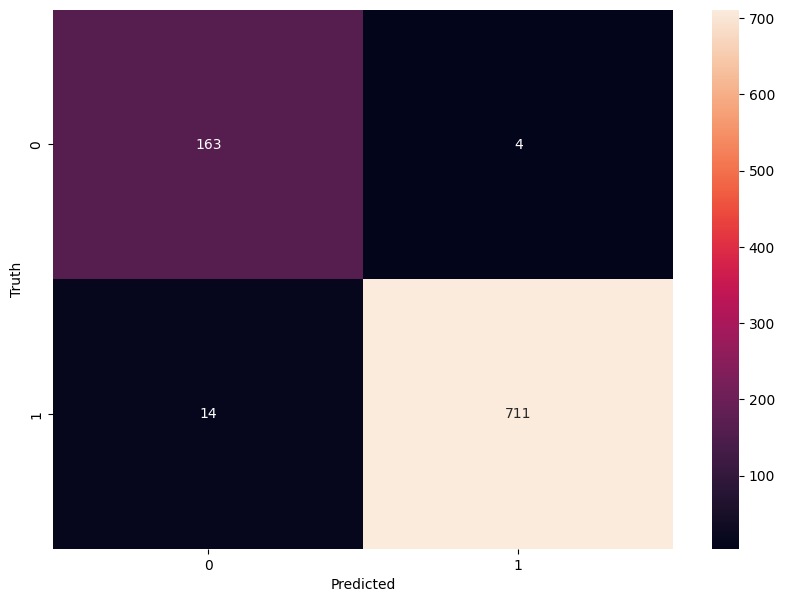

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Suponha que você tenha um modelo treinado chamado 'model'
# E você usa o conjunto de validação para fazer previsões
y_pred = model.predict(val_ds)

# Converta as previsões em rótulos de classe
y_pred_classes = np.argmax(y_pred, axis=1)

# Obtenha os rótulos verdadeiros do conjunto de validação
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Calcule a matriz de confusão
cm = confusion_matrix(y_true, y_pred_classes)

# Visualize a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [26]:
import numpy as np

# Suponha que `model.predict(val_ds)` retorne um array bidimensional, onde cada linha representa uma amostra e cada coluna representa a probabilidade de uma classe
predictions = model.predict(val_ds)

# Encontre a classe com a maior probabilidade para cada amostra
predicted_classes = np.argmax(predictions, axis=1)

# Encontre a probabilidade da classe prevista para cada amostra
predicted_probabilities = np.max(predictions, axis=1)

import os
import tensorflow as tf

from pathlib import Path

data_dir = Path("data/cuted")

batch_size = 32
img_height = 180
img_width = 180

# Obtenha a lista de todos os arquivos de imagem
all_image_paths = list(data_dir.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]

# Divida a lista de caminhos de imagem em conjuntos de treinamento e validação
train_image_paths = all_image_paths[:int(len(all_image_paths)*0.8)]
val_image_paths = all_image_paths[int(len(all_image_paths)*0.8):]

# Crie um tf.data.Dataset a partir dos caminhos de imagem
list_ds = tf.data.Dataset.from_tensor_slices(val_image_paths)

# Função para carregar e pré-processar as imagens
def process_path(file_path):
  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [img_height, img_width])
  img /= 255.0
  return img

# Crie um tf.data.Dataset de imagens
val_ds = list_ds.map(process_path).batch(batch_size)

# Agora você tem uma lista `val_image_paths` contendo os caminhos de todas as imagens no conjunto de validação
# Você pode usar esta lista para obter o nome do arquivo de imagem durante a predição
for i in range(len(predicted_classes)):
  
    print(f"Sample {os.path.basename(val_image_paths[i])}: Class {class_names[predicted_classes[i]]}, Probability {predicted_probabilities[i]}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
Sample page_384_p3_cropped.png: Class non-header, Probability 39.17122268676758
Sample page_452_p5_cropped.png: Class header, Probability 0.9493753910064697
Sample page_679_p1_cropped.png: Class non-header, Probability 7.1500349044799805
Sample page_2547_p7.png: Class non-header, Probability 8.768838882446289
Sample page_736_p3_cropped.png: Class non-header, Probability 6.404494762420654
Sample page_788_p1_cropped.png: Class header, Probability 9.612873077392578
Sample page_527_p2_cropped.png: Class non-header, Probability 2.4403486251831055
Sample page_801_p2_cropped.png: Class non-header, Probability 13.226053237915039
Sample page_2316_p7.png: Class non-header, Probability 1.8699791431427002
Sample page_625_p3_cropped.png: Class non-header, Probability 9.853999137878418
Sample page_594_p4_cropped.png: Class non-header, Probability 1.7922636270523071
Sample page_414_p1_cropped.png: Class non-header, Probability 9.742809295654297
Sample page_1158